In [14]:
import jax 
import jax.numpy as jnp 
from tinygp import kernels, GaussianProcess
jax.config.update("jax_enable_x64", True)
import jaxopt 

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.datasets import co2

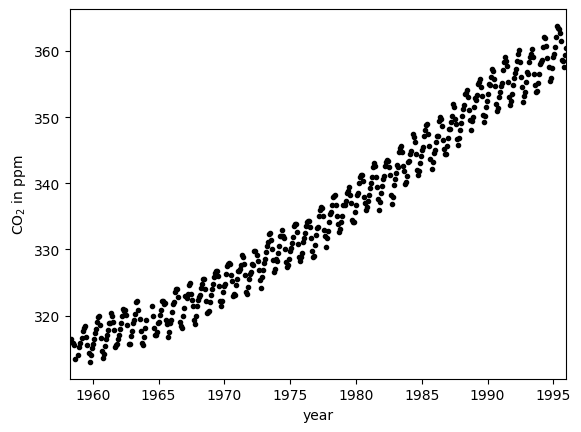

In [5]:
data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]

plt.plot(t, y, ".k")
plt.xlim(t.min(), t.max())
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

In [11]:

def build_gp(theta, X):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * kernels.ExpSquared(scales[0])
    k2 = (
        amps[1]
        * kernels.ExpSquared(scales[1])
        * kernels.ExpSineSquared(
            scale=jnp.exp(theta["log_period"]),
            gamma=jnp.exp(theta["log_gamma"]),
        )
    )
    k3 = amps[2] * kernels.RationalQuadratic(
        alpha=jnp.exp(theta["log_alpha"]), scale=scales[2]
    )
    k4 = amps[3] * kernels.ExpSquared(scales[3])
    kernel = k1 + k2 + k3 + k4

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )

def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)

In [12]:
theta_init = {
    "mean": np.float64(340.0),
    "log_diag": np.log(0.19),
    "log_amps": np.log([66.0, 2.4, 0.66, 0.18]),
    "log_scales": np.log([67.0, 90.0, 0.78, 1.6]),
    "log_period": np.float64(0.0),
    "log_gamma": np.log(4.3),
    "log_alpha": np.log(1.2),
}

In [13]:
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))
print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)


2024-05-20 13:58:52.566657: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Initial negative log likelihood: 392.9423118569882
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': Array(3.3025811, dtype=float64), 'log_amps': Array([-56.37950098,   1.71669126,   4.11084749,  -2.13098285], dtype=float64), 'log_diag': Array(60.28268107, dtype=float64), 'log_gamma': Array(12.52278878, dtype=float64), 'log_period': Array(2339.70173767, dtype=float64), 'log_scales': Array([117.65693454,  -3.10865356, -27.13290445,  -4.04980878], dtype=float64), 'mean': Array(-0.15787706, dtype=float64)}


In [16]:
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 296.59832192632456


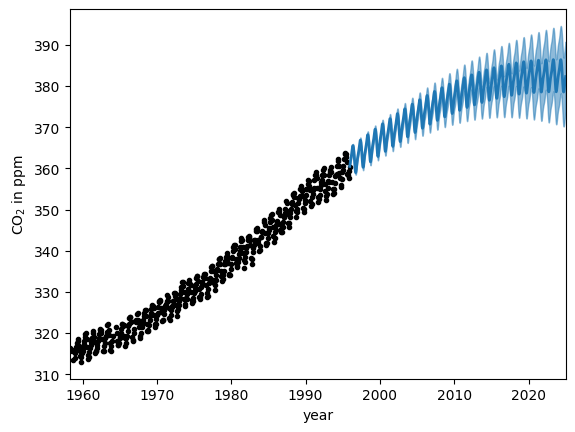

In [18]:
x = np.linspace(max(t), 2025, 2000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp 
mu, var = cond_gp.loc, cond_gp.variance 

plt.plot(t, y, ".k")
plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5)
plt.plot(x, mu, color="C0", lw=2)

plt.xlim(t.min(), 2025)
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")